In [1]:
import kwant
import kwant.continuum
import scipy.sparse.linalg

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
a=1

C:\Users\hhsomek\Anaconda3\envs\kwant\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [16]:
hamiltonian = "k_x**2 + k_y**2 - mu + V(x, y)"
template = kwant.continuum.discretize(hamiltonian,grid=a)
#print(template)

Lx=10000
Ly=1

def stadium(site):
    (x, y) = site.pos
    return (0 <= x < Lx and 0 <= y < Ly)

def lead_shape(site):
    (x, y) = site.pos
    return (0 <= y < Ly)

syst = kwant.Builder()
syst.fill(template, stadium, (0, 0))

lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
lead.fill(template, lead_shape, (0, 0))

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()

In [17]:
%%time
def potential(d1,d2,V1,V2):
    xperiod=d1+d2
    def heaviside(d1,xmod,y):
        if xmod<d1:
            return V1
        else:
            return V2
    def super_lattice(x,y):
        if 0<= y <Ly:
            return heaviside(d1, (x)%xperiod,y)
    return super_lattice

Wall time: 0 ns


In [18]:
%%time
NV=101
NE=1001

energy=np.linspace(1.800001,6.200001,NE)
volt_arr=np.linspace(0.0,0.7,NV)
trans_surf_VV=np.zeros([NV,NE])

d1=20
d2=20

for i in range(NV):
    print(f'\r{i}.step', end='', flush=True)
    #print(i,'. step')
    params=dict(mu=0.,V=potential(d1,d2,volt_arr[i],-volt_arr[i]))
    for j in range(NE):
        #print(f'\r{j}.step', end='', flush=True)
        smatrix = kwant.smatrix(syst, energy[j], params=params)
        trans_surf_VV[i,j]=(smatrix.transmission(1, 0))
    #print('\n')

100.stepWall time: 3h 19min 15s


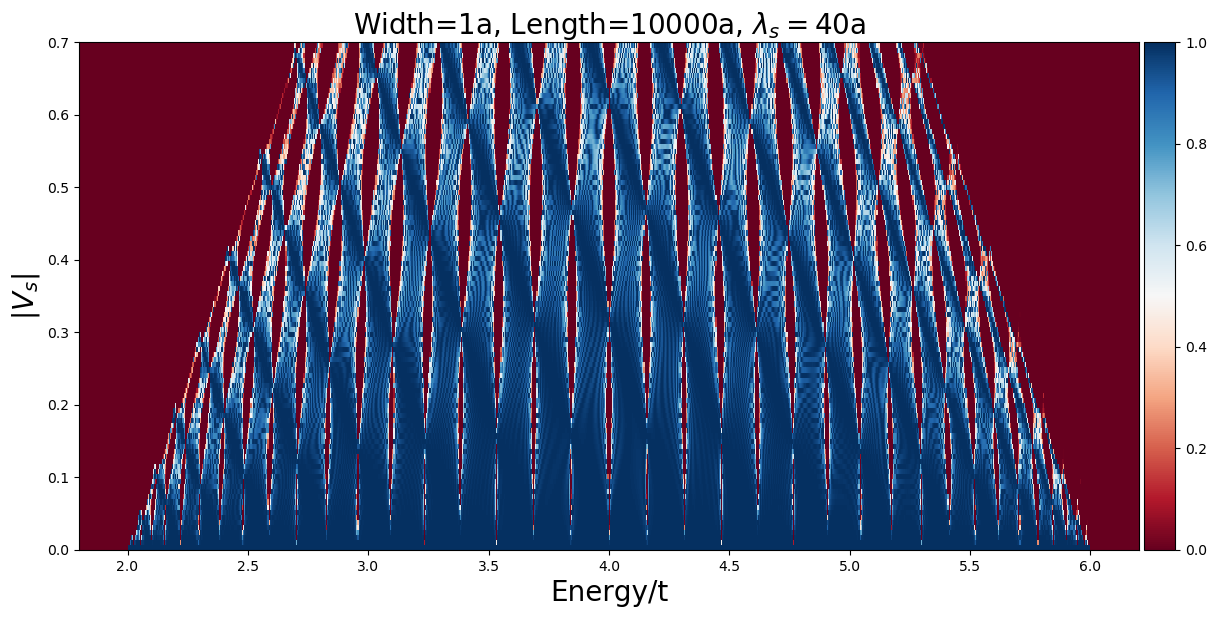

In [21]:
np.savetxt('SL_1D_cond_amp_vs_ener_Ly={0}_Lx={1}_Vmax={2:.2f}_xper={3}_NV={4}_NE={5}.txt'.format(Ly, Lx, volt_arr[-1], d1+d2, NV, NE),trans_surf_VV,fmt='%.18e')
EE,VV=np.meshgrid(energy,volt_arr)

fig, ax = plt.subplots(1, 1, dpi=100, figsize=(12,6), constrained_layout=False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)

ax.set_title('Width={0}a, Length={1}a, $\lambda_s=${2}a'
             .format(Ly, Lx, d1+d2),fontsize=20)

im=ax.pcolor(EE,VV,(trans_surf_VV),cmap='RdBu')
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel('Energy/t',fontsize=20)
ax.set_ylabel('$|V_{s}|$',fontsize=20)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
plt.tight_layout(pad=0.1)
plt.savefig('SL_1D_cond_amp_vs_ener_Ly={0}_Lx={1}_Vmax={2:.2f}_xper={3}_NV={4}_NE={5}.png'.format(Ly, Lx, volt_arr[-1], d1+d2, NV, NE))